# 3. Topic Embedding

In this notebooks, we explore the topic embeddings and use it as a latent variable that connects tasks to constructs.

In [4]:
import pandas as pd
import numpy as np

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from bertopic import BERTopic
from top2vec import Top2Vec

import torch
from torch import nn
import torch.nn.functional as F

## Parameters

In [5]:
PUBMED_PATH = Path('data/pubmed_abstracts.csv.gz')

MODEL_NAME = 'pubmed10pct_top2vec'
VERSION = 'v202110131'

MODEL_NAME = 'pubmed1pct_bertopic'
VERSION = 'v202110142'

## Load the trained model

In [6]:
if 'top2vec' in MODEL_NAME:

  model: Top2Vec = Top2Vec.load(f'models/{MODEL_NAME}_{VERSION}.model')

  # documents
  PUBMED = pd.read_csv(PUBMED_PATH)
  PUBMED = PUBMED.query('pmid in @model.document_ids').copy()
  PUBMED['label'] = PUBMED['subcategory'].astype('category')

  # scores data frame
  scores = np.load(f'models/{MODEL_NAME}_{VERSION}.scores.npz')['arr_0']
  scores = PUBMED['pmid'].apply(lambda pmid: pd.Series(scores[model.doc_id2index[pmid]]))
  scores['pmid'] = PUBMED['pmid']
  scores['doc_id'] = scores['pmid'].apply(lambda pmid: model.doc_id2index[pmid])
  scores['label'] = PUBMED['label']

elif 'bertopic' in MODEL_NAME:
  # BERTOPIC
  trained_indices = np.load(f'models/{MODEL_NAME}_{VERSION}.idx.npz',allow_pickle=True)['arr_0']
  # indices are stored as (label, idx), we only need the second aprt
  trained_indices = np.array([i[1] for i in trained_indices])
  
  model: BERTopic = BERTopic.load(f'models/{MODEL_NAME}_{VERSION}.model')
  topics = np.load(f'models/{MODEL_NAME}_{VERSION}.topics.npz')['arr_0']
  
  PUBMED = pd.read_csv(PUBMED_PATH)
  PUBMED = PUBMED[PUBMED.index.isin(trained_indices)]
  PUBMED['label'] = PUBMED['subcategory'].astype('category')

  scores = np.load(f'models/{MODEL_NAME}_{VERSION}.scores.npz')['arr_0']
  scores = pd.DataFrame(scores, index=PUBMED.index)
  scores['label'] = PUBMED['label']


In [71]:
model.calculate_probabilities = True
docs = PUBMED['abstract'].to_list()
labels = PUBMED['label'].to_list()

model.hdbscan_model
topics, probs = model.transform(docs[:10])
ptopics = model._map_predictions(probs.argmax(axis=1))
topics, ptopics, probs.argmax(axis=1)
docs[3], model.get_topic(topic=probs[3].argsort()[0].item())

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


("Processing of contextual information is essential for the establishment of good interpersonal relations and communicational interactions. Nevertheless, it is known that schizophrenic patients present impairments in the processing of contextual information. The aim of this study is to explore the influence of the remediation of context processing in schizophrenic patients. Thirty-one schizophrenic patients and 28 matched healthy participants were included in this study. All participants were assessed on verbal knowledge (Mill-Hill test) and depression intensity (Beck Depression Scale 21 items). Schizophrenic patients were also assessed on thought, language, and communication disorders (Thought, Language and Communication scale). All participants completed a disambiguation task with two different levels of contextualization (high or low context) and a context-processing remediation task containing social scenarios that included ambiguous words and were presented with two different type

In [7]:
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# DEBUG simulated dataset
# n_topics = 300
# n_samples = 1000
# n_labels = 10
# X, y = make_classification(n_samples=n_samples, n_features=n_topics, n_classes=n_labels, n_informative=10, random_state=0)


# Tensorboard logger
logger = SummaryWriter()

# training parameter
n_epoches = 1000
batch_size = 1000

# prepare the X and y and parameters
X = scores.drop(columns=['pmid','doc_id'], errors='ignore').values
y = PUBMED['label'].cat.codes.values
n_topics = X.shape[1]
n_samples = X.shape[0]
n_labels = y.max() + 1
train_size = int(n_samples * .9)
test_size = n_samples - train_size

# prepare the test/train datasets
X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.long)
dataset = TensorDataset(X, y)
train_subset, test_subset = random_split(dataset, lengths=(train_size, test_size))
X_test, y_test = dataset[test_subset.indices]

model = nn.Sequential(
  nn.Embedding(n_labels, n_topics)
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

logger.add_graph(model, y)

trace = []

for epoch in tqdm(range(n_epoches)):

  model.train()
  for X_batch, y_batch in DataLoader(train_subset, batch_size=batch_size, shuffle=True):
    model.zero_grad()
    X_pred = model(y_batch)
    loss = criterion(X_batch, X_pred)
    logger.add_scalar('loss/train', loss.detach(), epoch)
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad():
    X_pred = model(y_test)
    loss = criterion(X_test, X_pred)
    logger.add_scalar('loss/test', loss.detach(), epoch)


H = pd.DataFrame(next(model.parameters()).detach().numpy())


ModuleNotFoundError: No module named 'tensorboard'

# Maximum Likelihood Estimator

Assuming all the observed scores of each label are drawn from a normal distribution, we will use MLE to estimate the topic embeddings of the labels from observed values of the documents.

In [24]:
# MLE

# FIXME the distribution of scores is positive values skewed toward zero. HalfNormal, LogNormal, or Exponential might be better choice for the MLE.

H = scores.drop(columns=['pmid','doc_id'], errors='ignore').groupby('label').apply(
  lambda data: data.mean()
).reset_index(0)

H

,label,0,1,2,3,4,5,6,7,8,...,88,89,90,91,92,93,94,95,96,97
0,AnalogyMakingTask,5.742122e-04,1.366674e-03,1.226047e-03,1.902570e-03,1.982022e-03,9.610918e-04,9.173438e-04,1.607657e-03,1.910463e-03,...,1.891525e-03,2.043500e-03,2.265232e-03,2.070890e-03,1.915552e-03,1.507377e-03,1.635645e-03,1.642490e-03,1.538597e-03,1.650506e-03
1,AntiSaccadeTask,7.587462e-04,1.619983e-03,1.893852e-03,2.088162e-03,2.845912e-03,1.541777e-03,1.478330e-03,2.917995e-03,3.232093e-03,...,3.094488e-03,3.467933e-03,3.756363e-03,3.232978e-03,3.040418e-03,2.474801e-03,2.848432e-03,2.403571e-03,2.478492e-03,2.580367e-03
2,Attention,1.059338e-01,4.638179e-03,2.167378e-03,1.539978e-02,1.441042e-02,1.101868e-02,1.593071e-02,4.569706e-03,4.764553e-03,...,4.363197e-03,5.918926e-03,1.025037e-02,3.303173e-03,3.806619e-03,3.489721e-03,6.375524e-03,7.361579e-03,6.098952e-03,4.919346e-03
3,AttentionNetworkTest,7.298773e-04,1.367546e-03,2.956902e-03,1.699361e-03,1.481978e-03,1.440705e-01,7.637613e-03,2.384271e-03,1.768565e-03,...,5.260244e-03,5.467682e-03,6.000848e-03,4.584272e-03,6.555288e-03,4.151781e-03,5.232829e-03,5.532731e-03,5.240364e-03,5.066899e-03
4,AttentionalControl,9.696581e-03,1.810282e-03,1.676937e-03,1.012210e-02,2.736962e-03,1.403994e-03,1.356956e-03,2.350799e-02,3.123530e-03,...,3.431917e-03,2.518465e-02,4.159042e-03,2.794221e-03,2.894097e-03,2.737953e-03,3.175355e-03,2.912797e-03,2.907641e-03,3.083339e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,VisuospatialSketchpad,1.379420e-03,2.275430e-03,2.463632e-03,3.957720e-03,3.369167e-03,2.141523e-03,2.068965e-03,5.035298e-03,4.397232e-03,...,3.464109e-02,1.566299e-02,1.574248e-02,8.030636e-03,1.008200e-02,5.126018e-02,1.719870e-01,2.560395e-02,3.368728e-02,7.085586e-02
168,VisuospatialWorkingMemory,3.240004e-308,7.584500e-308,7.263576e-308,8.230819e-308,1.951956e-307,6.131535e-308,6.011604e-308,6.494594e-308,1.308803e-307,...,6.799782e-308,7.112563e-308,7.365907e-308,6.424266e-308,6.190533e-308,6.045484e-308,6.539724e-308,5.903516e-308,5.957957e-308,6.245890e-308
169,Volition,1.482668e-03,3.194916e-03,2.888151e-03,3.507949e-02,4.153290e-03,2.328290e-03,2.246362e-03,2.426627e-03,4.593199e-03,...,3.251222e-03,3.059974e-03,3.337928e-03,2.784743e-03,2.800113e-03,2.862553e-03,2.966470e-03,2.854700e-03,2.703478e-03,2.960504e-03
170,WCST_-_Wisconsin_Card_Sort_Test,2.618890e-02,1.657764e-03,1.632579e-03,1.591450e-02,2.283096e-03,1.348491e-03,1.299075e-03,2.139857e-03,2.857891e-03,...,3.328773e-03,4.974621e-03,4.154801e-03,3.034869e-03,3.665283e-03,2.758393e-03,4.031552e-02,3.027871e-03,3.185088e-03,3.121806e-03


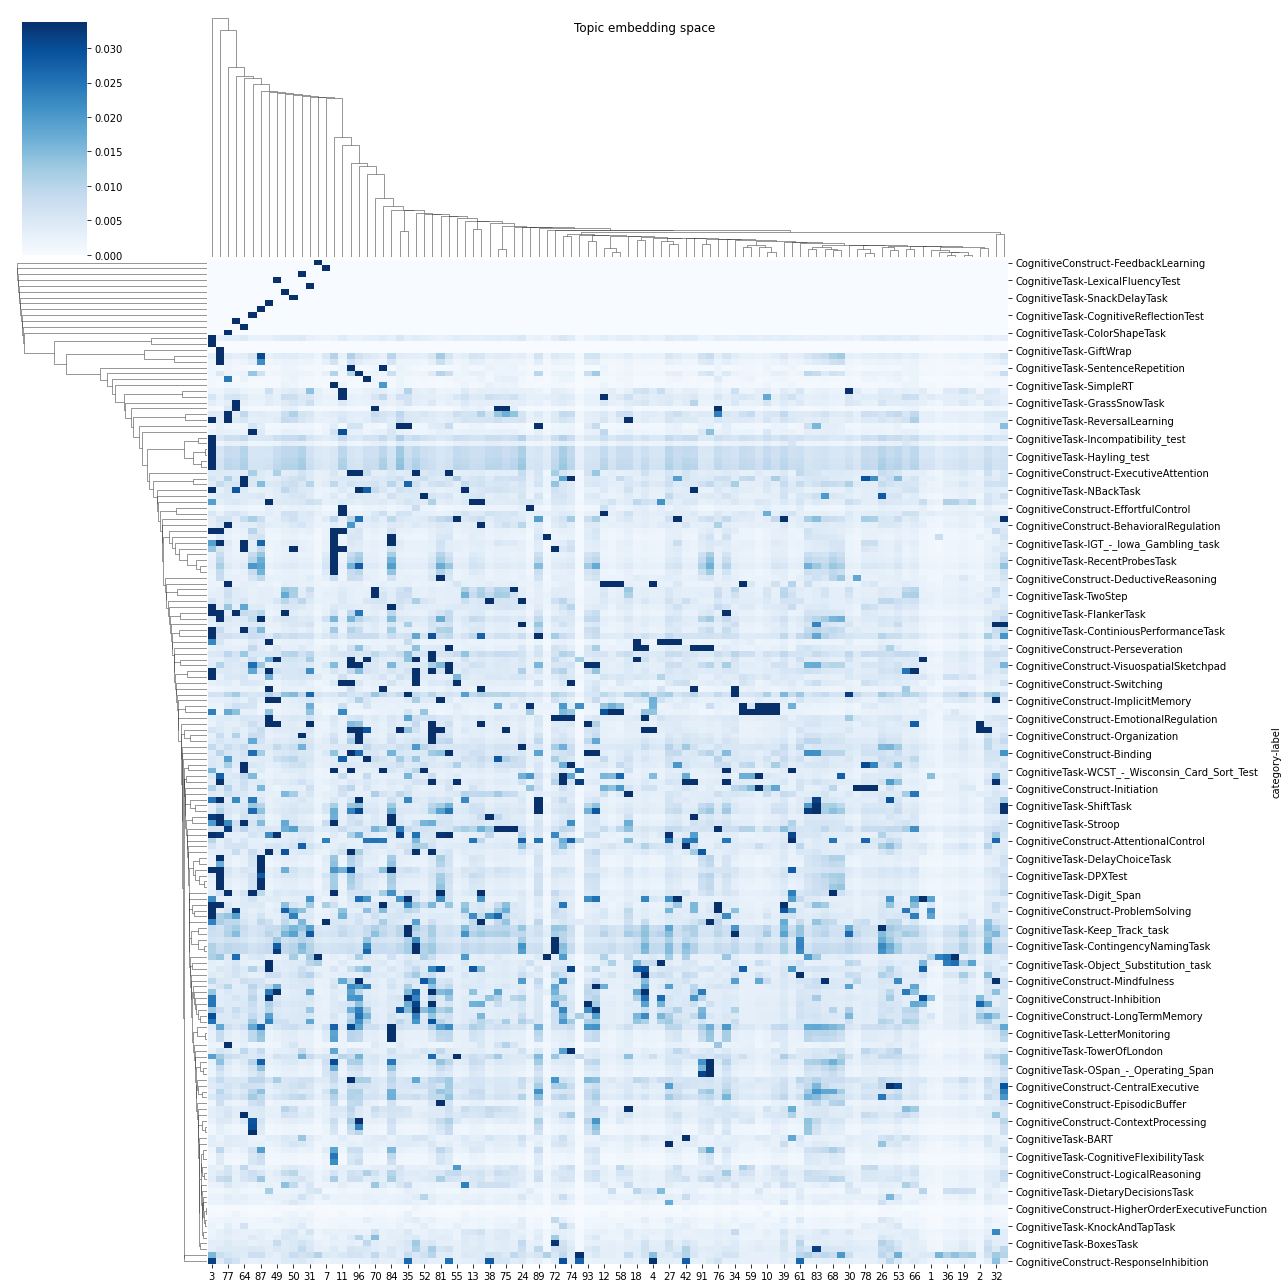

In [25]:

# convert to a dataframe, indexed by label and category
labels = PUBMED['label'].cat.categories[H.index]
categories = labels.to_series().apply(lambda lbl: PUBMED.query('label == @lbl')['category'].unique().item())
indices = categories.to_frame().reset_index().rename(columns={0: 'category', 'index': 'label'})
H.index = pd.MultiIndex.from_frame(indices).reorder_levels(['category', 'label'])
H.drop(columns=['label'], errors='ignore', inplace=True)
# DEBUG H = H.query('not index.get_level_values("label").str.contains("ColumbiaCardTask")')

sns.clustermap(H, figsize=(18, 18), cmap='Blues', robust=True)
plt.suptitle('Topic embedding space')
plt.show()


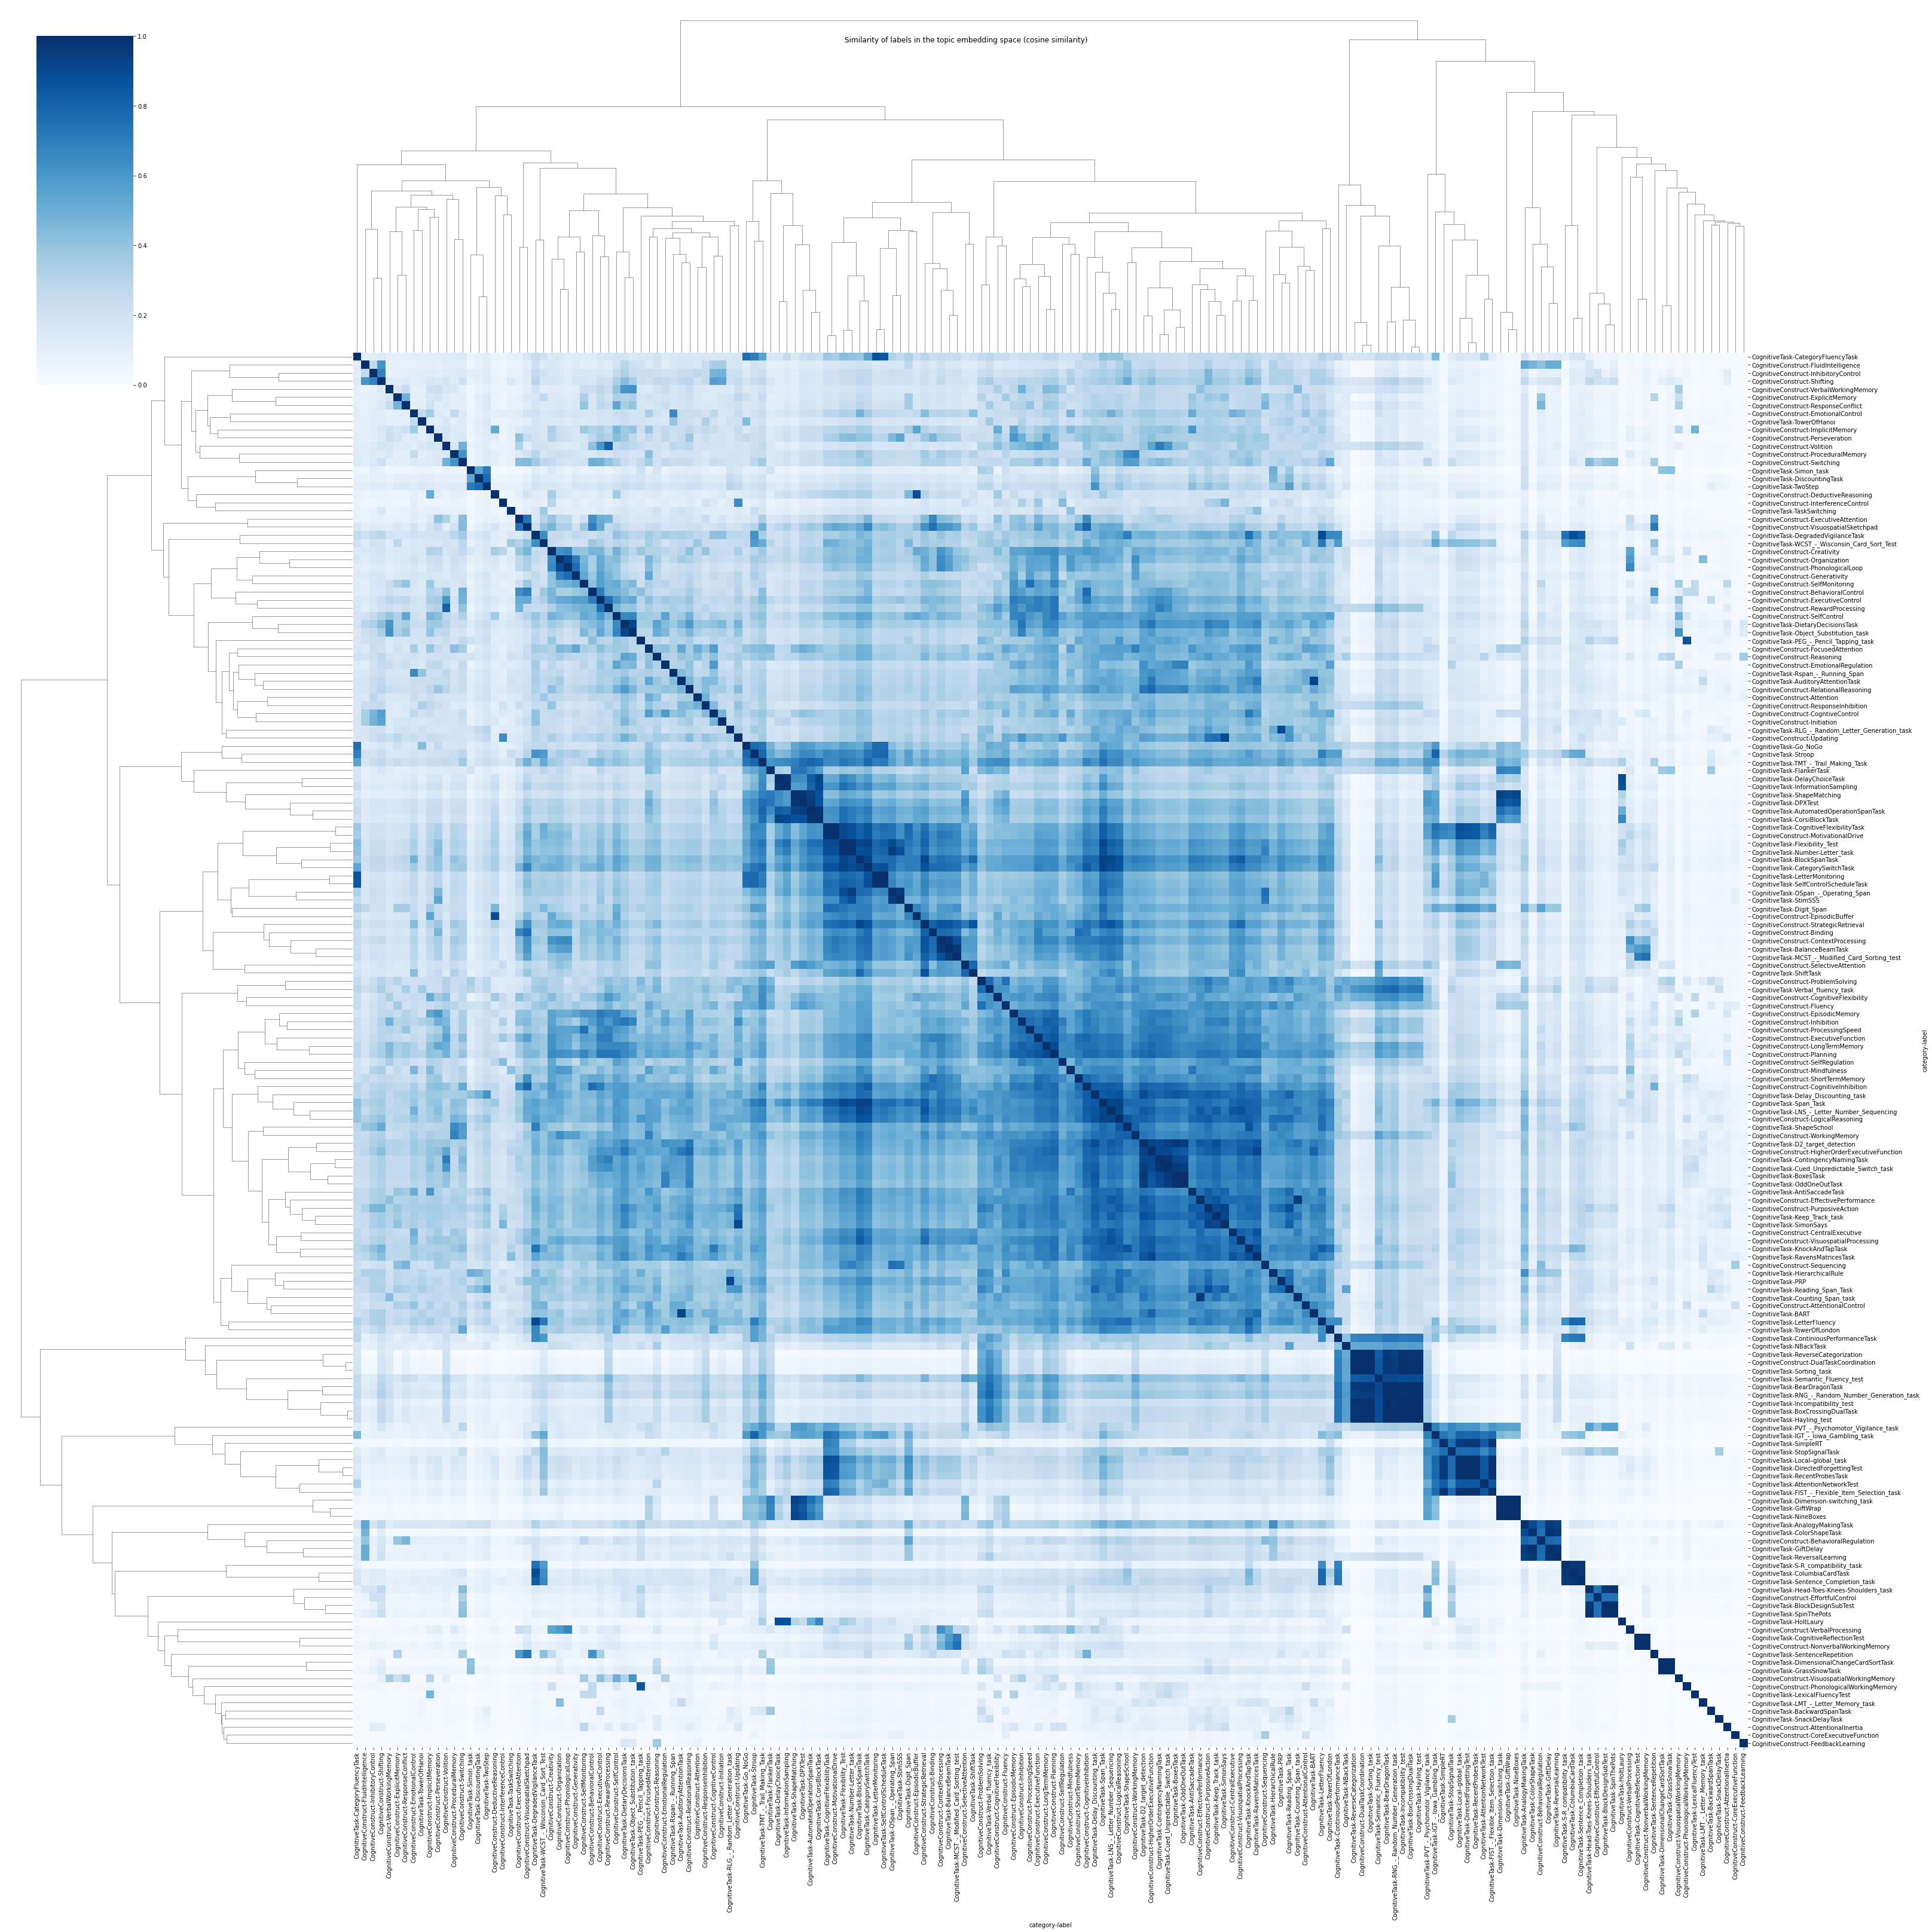

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
H_sim = pd.DataFrame(cosine_similarity(H), columns=H.index, index=H.index)
sns.clustermap(H_sim, cmap='Blues', figsize=(45,45))
plt.suptitle('Similarity of labels in the topic embedding space (cosine similarity)')
plt.show()

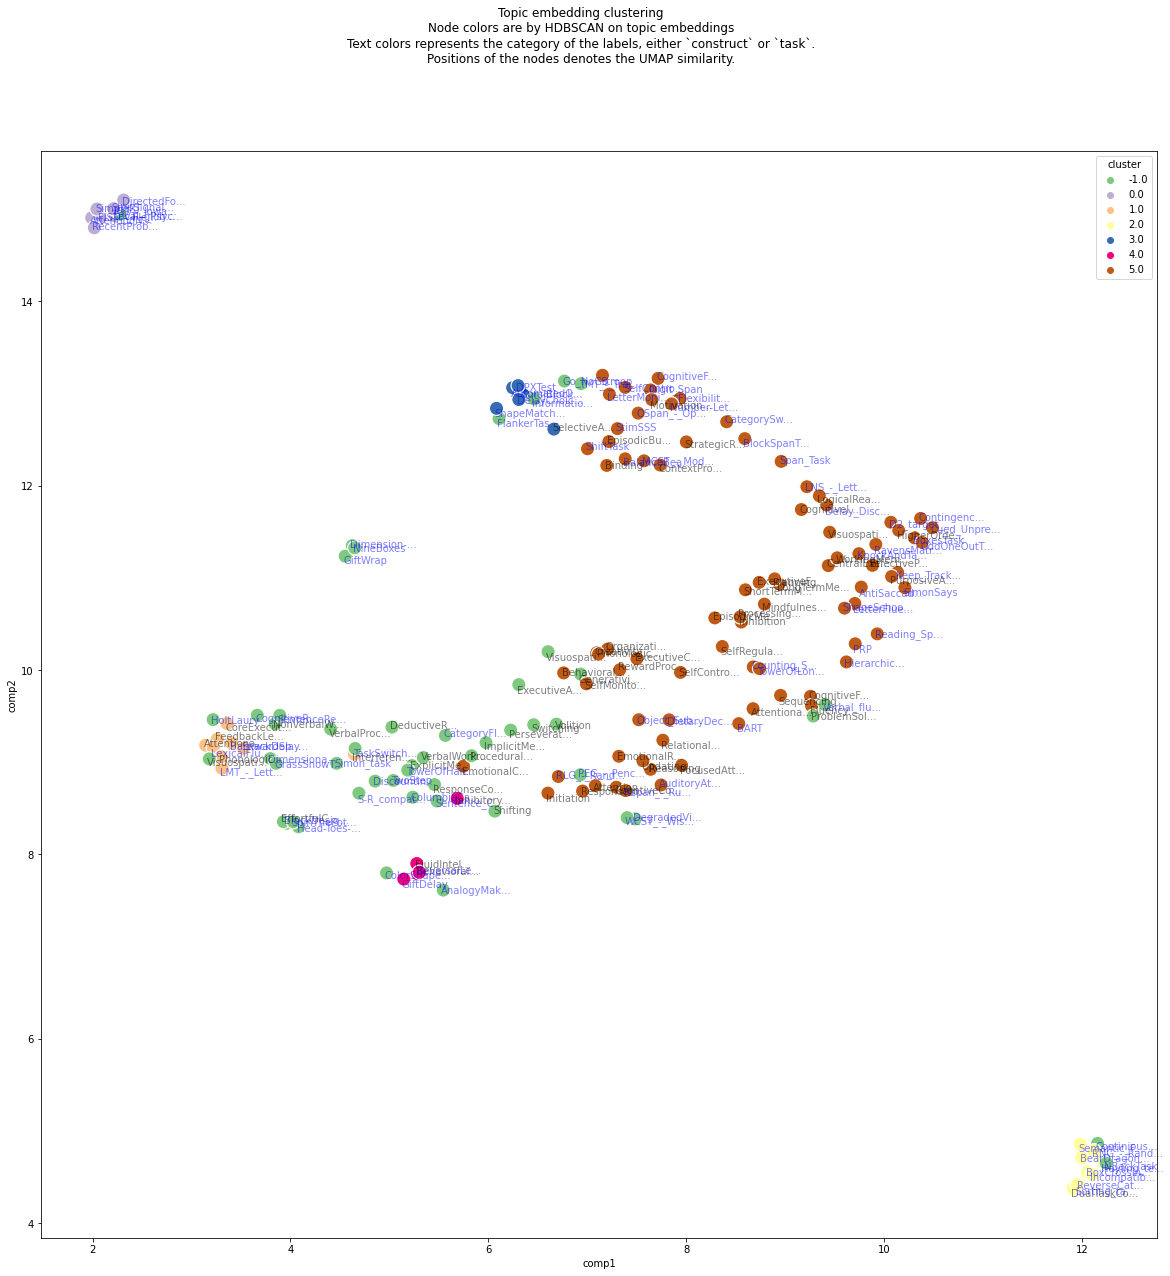

In [27]:
import hdbscan
import umap
from sklearn.decomposition import PCA


H_projection = umap.UMAP(n_components=2, random_state=0).fit_transform(H_sim)
# H_projection = PCA(n_components=2, random_state=0).fit_transform(H)

clusters = hdbscan.HDBSCAN().fit_predict(H_sim).reshape(-1,1)

cat_colors_palette = ['black','blue']
cat_colors = H.index.to_frame()['category'].astype('category').cat.codes.to_list()
cat_colors = [cat_colors_palette[c] for c in cat_colors]

H_projection = np.hstack((H_projection, clusters))

fig, ax = plt.subplots(1,1, figsize=(20,20))

sns.scatterplot(
    data=pd.DataFrame(H_projection, columns=['comp1', 'comp2', 'cluster']),
    x='comp1', y='comp2', hue='cluster', ax=ax, palette='Accent', s=200)

for (cat, lbl), (x, y, c), color in zip(H.index.to_list(), H_projection, cat_colors):
    lbl = f'{lbl[:10]}...' if len(lbl)>10 else lbl
    ax.text(x-0.02, y-np.random.random()*.1, f'{lbl}', alpha=0.5, fontsize=10, color=color)

plt.suptitle(
    'Topic embedding clustering\n'
    'Node colors are by HDBSCAN on topic embeddings\n'
    'Text colors represents the category of the labels, either `construct` or `task`.\n'
    'Positions of the nodes denotes the UMAP similarity.')
plt.show()
